In [1]:
from functions import *
from inverse_RTI import inverse_RTI_algo


parameters = {}

parameters['time'] = time.time()
parameters['num_devices'] = 20
parameters['device_indices'] = [x+1 for x in range(parameters['num_devices'])]

# device parameters
parameters['sample_rate'] = 1e6  # Hz
parameters['num_samples'] = 100  # number of samples per call to rx()
parameters['center_freq'] = 2.4e9  # Hz
parameters['bandwidth'] = 10  # Hz
parameters['transmitter_attenuation'] = 0  # dB
parameters['receiver_gain'] = 40  # dB

# imaging parameters
parameters['doi_size'] = 3
parameters['alpha'] = 1e2  # 1e2
parameters['grid_resolution'] = 0.1
parameters['detection_size'] = 0.1
parameters['pixel_size'] = (int(parameters['doi_size']/parameters['grid_resolution']), int(parameters['doi_size']/parameters['grid_resolution']))

parameters['eterm'] = 1

signal = generate_signal()

devices = init_devices(parameters)


In [2]:
counter = 0
while True:
    counter += 1
    np.save(f'result/{counter}.npy', data_collection_once(parameters, signal, devices))
    print(counter)
    # time.sleep(10)
    input("Press Enter to continue...")


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [23]:
import scipy.io
import pathlib
from functions import *
from inverse_RTI import *
from xPRA import *


parameters = {}

parameters['time'] = time.time()
parameters['num_devices'] = 20
parameters['device_indices'] = [x+1 for x in range(parameters['num_devices'])]

# device parameters
parameters['sample_rate'] = 1e6  # Hz
parameters['num_samples'] = 100  # number of samples per call to rx()
parameters['center_freq'] = 2.4e9  # Hz
parameters['bandwidth'] = 10  # Hz
parameters['transmitter_attenuation'] = 0  # dB
parameters['receiver_gain'] = 40  # dBsim_result
parameters['wavelength'] = 3e8/parameters['center_freq']


# imaging parameters
parameters['doi_size'] = 3
parameters['alpha'] = 0.5  # 1e2
parameters['grid_resolution'] = 0.05
parameters['detection_size'] = 0.1
parameters['pixel_size'] = (int(parameters['doi_size']/parameters['grid_resolution']), int(parameters['doi_size']/parameters['grid_resolution']))

parameters['eterm'] = 1
parameters['k0'] = 2*np.pi/parameters['wavelength']
parameters['cellrad'] = (np.sqrt(parameters['grid_resolution']**2/np.pi)*2)/2


signal = generate_signal()

# devices = init_devices(parameters)

FrytB = xPRA_preparation(parameters)


plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 400


In [24]:

parameters['time'] = time.time()
parameters['num_devices'] = 20
parameters['device_indices'] = [x+1 for x in range(parameters['num_devices'])]

# device parameters
parameters['sample_rate'] = 1e6  # Hz
parameters['num_samples'] = 100  # number of samples per call to rx()
parameters['center_freq'] = 2.4e9  # Hz
parameters['bandwidth'] = 10  # Hz
parameters['transmitter_attenuation'] = 0  # dB
parameters['receiver_gain'] = 40  # dBsim_result
parameters['wavelength'] = 3e8/parameters['center_freq']


# imaging parameters
parameters['doi_size'] = 3
parameters['alpha'] = 0.5  # 1e2
parameters['grid_resolution'] = 0.05
parameters['detection_size'] = 0.1
parameters['pixel_size'] = (int(parameters['doi_size']/parameters['grid_resolution']), int(parameters['doi_size']/parameters['grid_resolution']))

parameters['eterm'] = 1
parameters['k0'] = 2*np.pi/parameters['wavelength']
parameters['cellrad'] = (np.sqrt(parameters['grid_resolution']**2/np.pi)*2)/2


signal = generate_signal()

# devices = init_devices(parameters)

FrytB, FrytBat = xPRA_preparation(parameters)


plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 400
plt.rcParams.update({'font.size': 5})

In [36]:
path = 'result'
test_files = sorted(list(pathlib.Path(path).glob('*.npy')))
parameters['flag'] = False
Pinc = np.load(test_files.pop(0))
Pinc = magnitude_to_db(abs(np.mean(np.squeeze(Pinc), axis=2)), parameters['receiver_gain'])
Pinc = Pinc[~np.eye(Pinc.shape[0], dtype=bool)].reshape(-1, 1)
scipy.io.savemat(path+f'/Pinc.mat', {'Pinc': Pinc.reshape((19, 20), order='F')})

result = []
for i, Ptot in enumerate(test_files):
    Ptot = np.load(Ptot)
    Ptot = magnitude_to_db(abs(np.mean(np.squeeze(Ptot), axis=2)), parameters['receiver_gain'])
    Ptot = Ptot[~np.eye(Ptot.shape[0], dtype=bool)].reshape(-1, 1)
    scipy.io.savemat(path+f'/Ptot{i+2}.mat', {'Ptot': Ptot.reshape((19, 20), order='F')})

    xPRA_result = xPRA(parameters, FrytB, FrytBat, Pinc, Ptot)
    result.append(xPRA_result)


In [26]:
def plot_test_ptot(result, title=None):
    fig, axs = plt.subplots(1, len(test_files))
    sub_titles = ['Bottom Left', 'Bottom Right', 'Top Right', 'Top Left']
    fig.subplots_adjust(top=0.8)
    
    for i in range(len(result)):

        im = axs[i].imshow(result[i], extent=[-1.5, 1.5, -1.5, 1.5], cmap='jet')
        fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)
        axs[i].set_title(f'[{i+1}]{sub_titles[i]}')
        
    fig.suptitle(title, weight='bold', y=0.64)
    plt.tight_layout()
    plt.show()

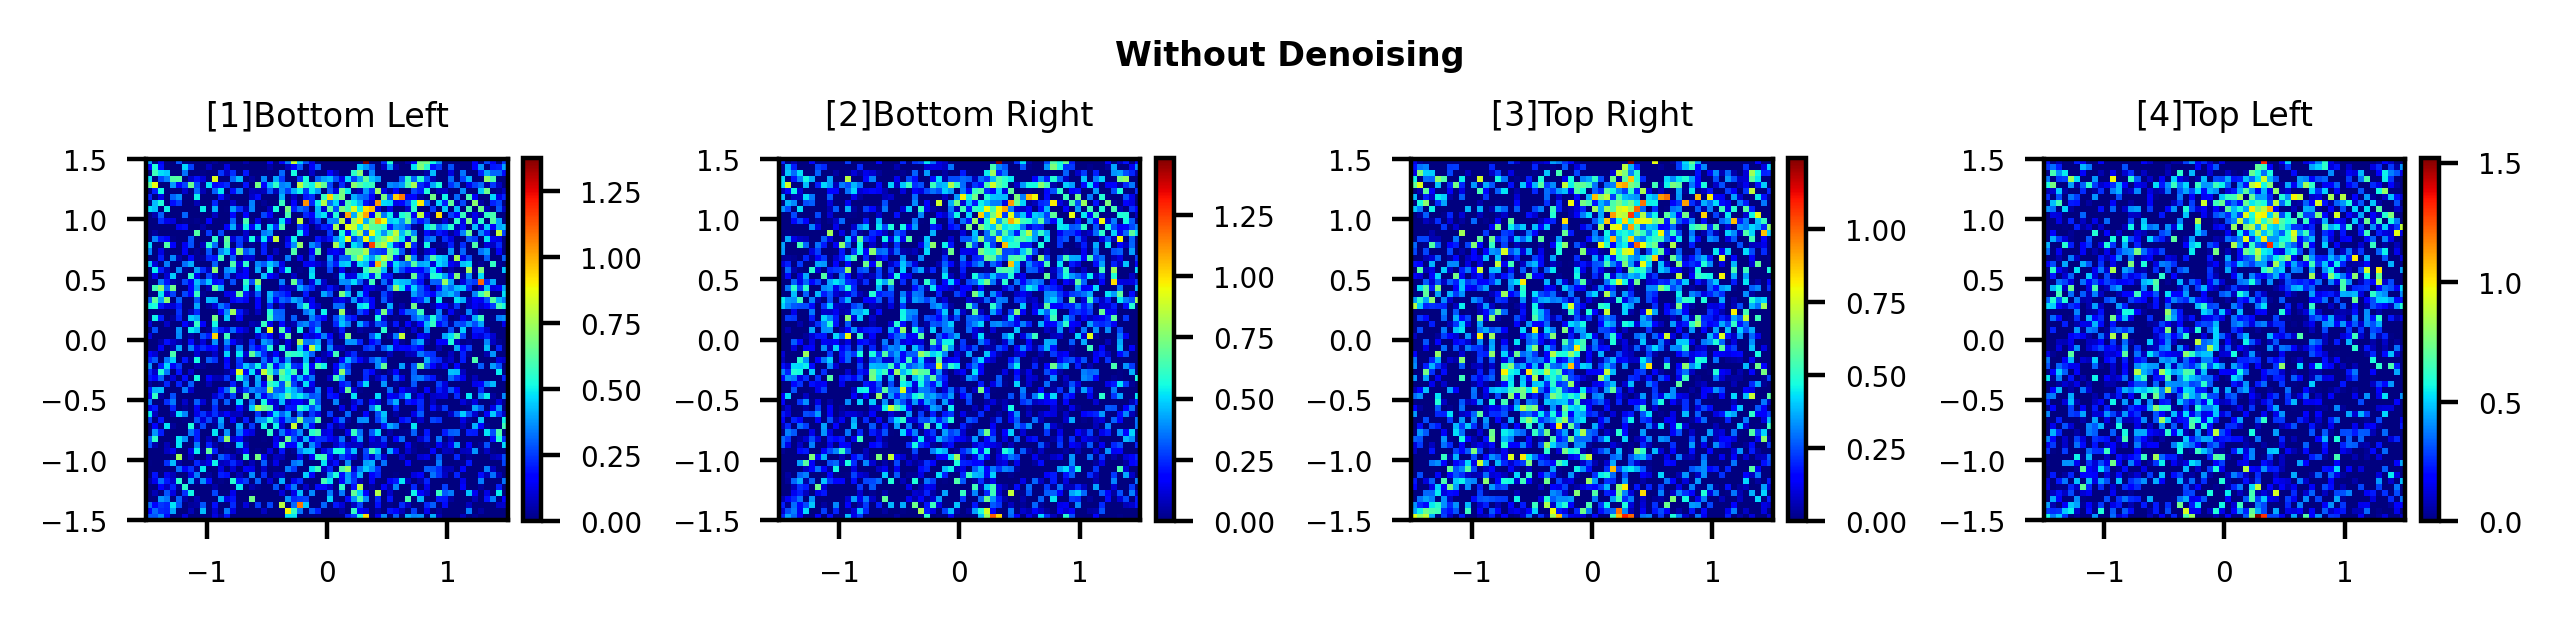

In [27]:
plot_test_ptot(result, 'Without Denoising')

In [28]:
# import bm3d
# sigma = 20.0 / 255  # noise standard deviation

# plot_test_ptot([bm3d.bm3d(x, sigma_psd=40 / 255) for x in result], 'BM3D')


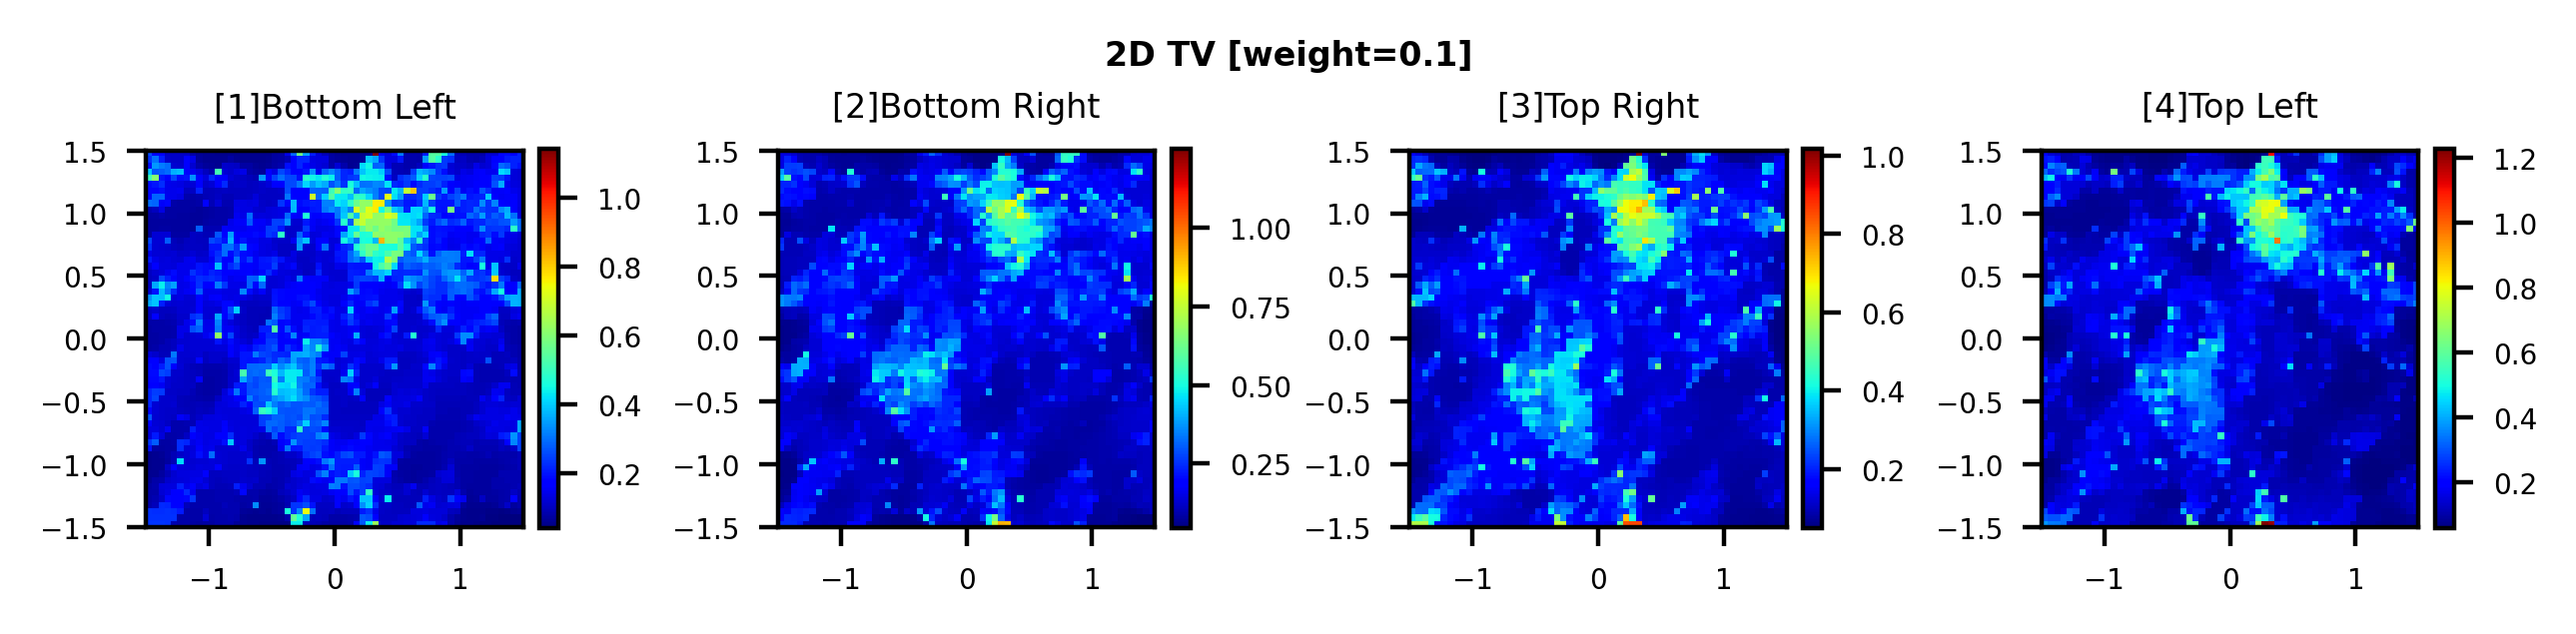

In [29]:
from skimage.restoration import denoise_tv_chambolle

weight = 0.1

plot_test_ptot([denoise_tv_chambolle(x, weight=weight) for x in result], f'2D TV [{weight=}]')


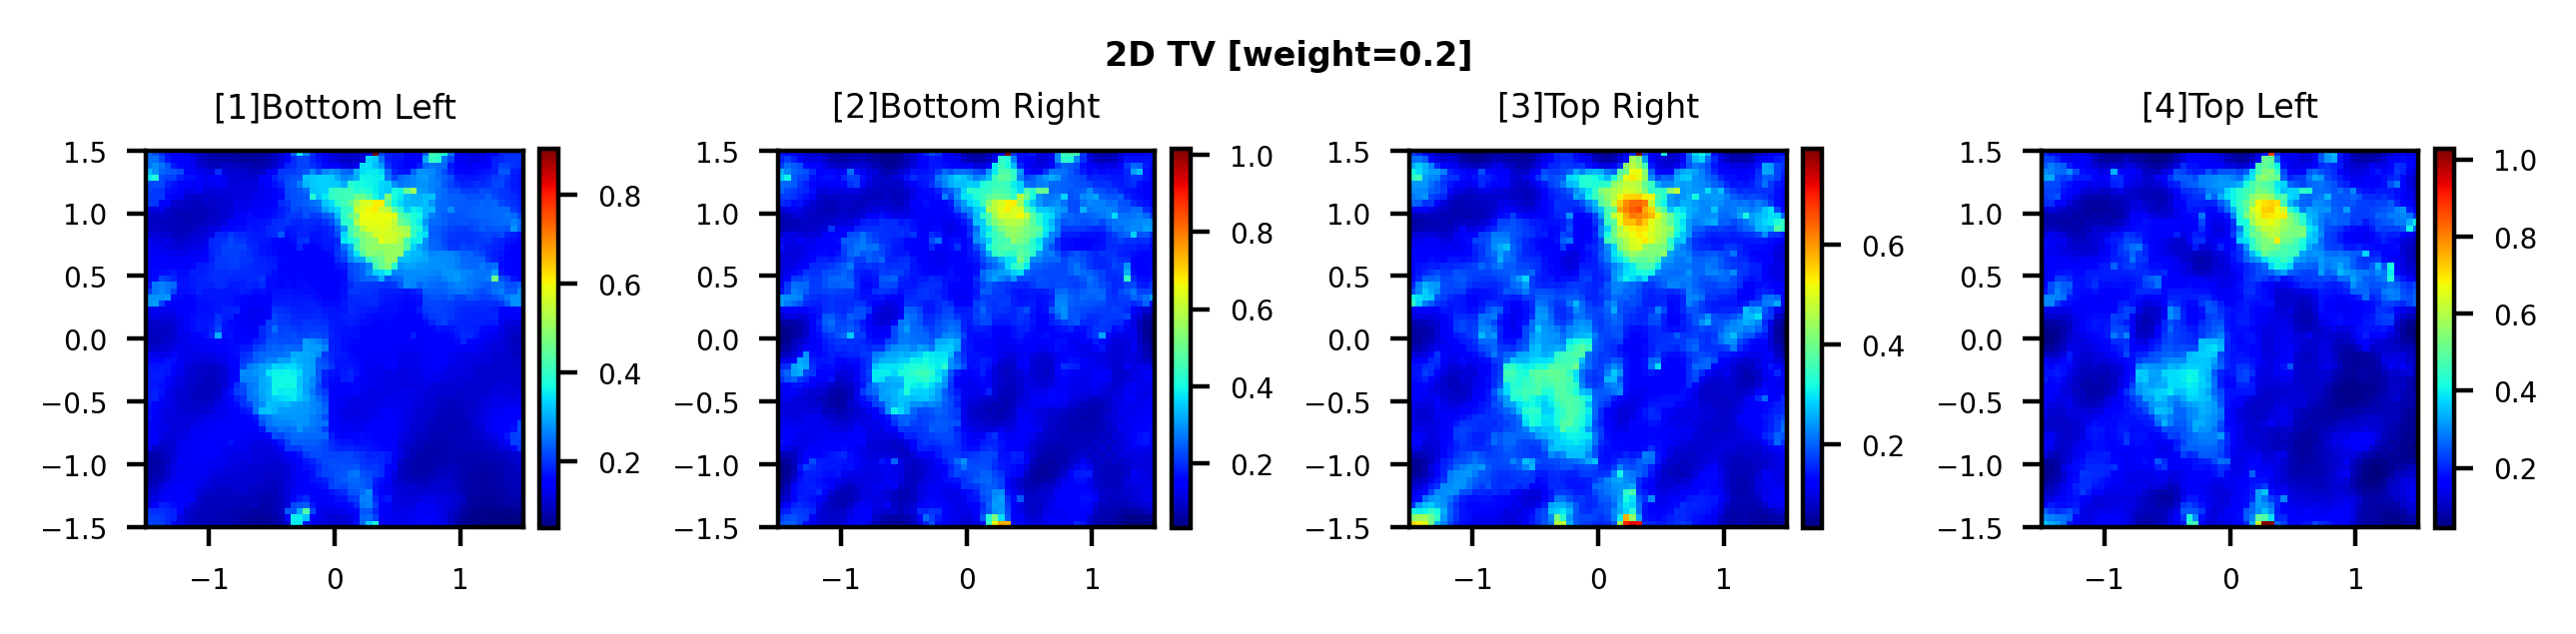

In [30]:
weight = 0.2

plot_test_ptot([denoise_tv_chambolle(x, weight=weight) for x in result], f'2D TV [{weight=}]')


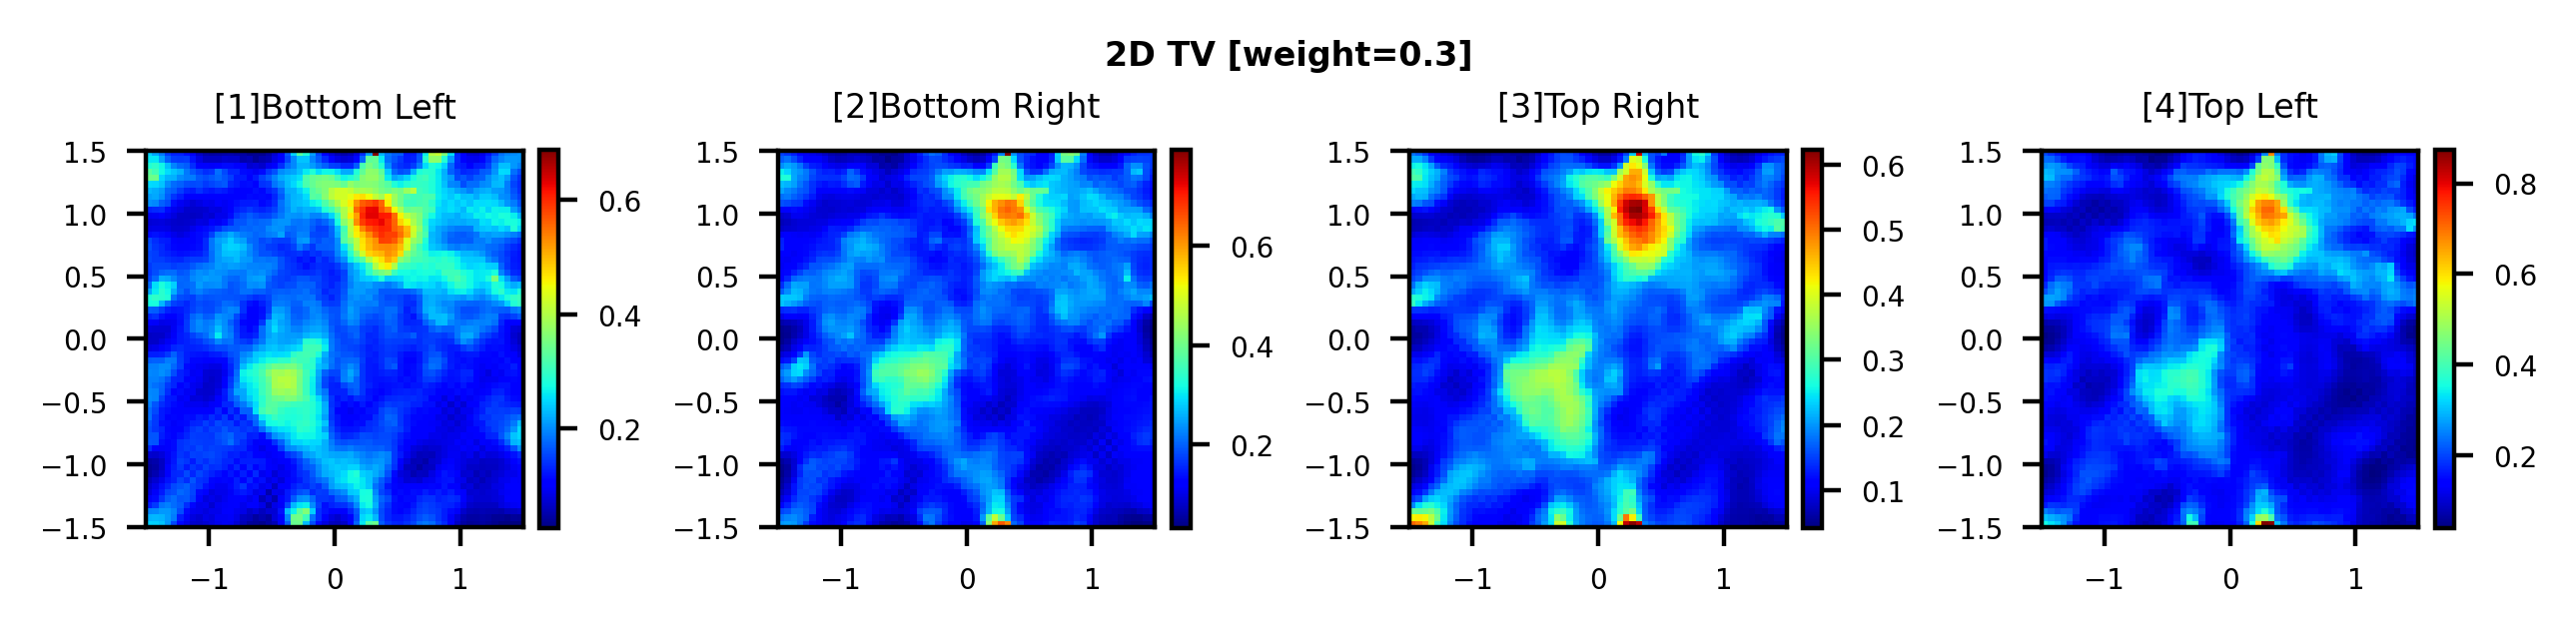

In [31]:
weight = 0.3

plot_test_ptot([denoise_tv_chambolle(x, weight=weight) for x in result], f'2D TV [{weight=}]')


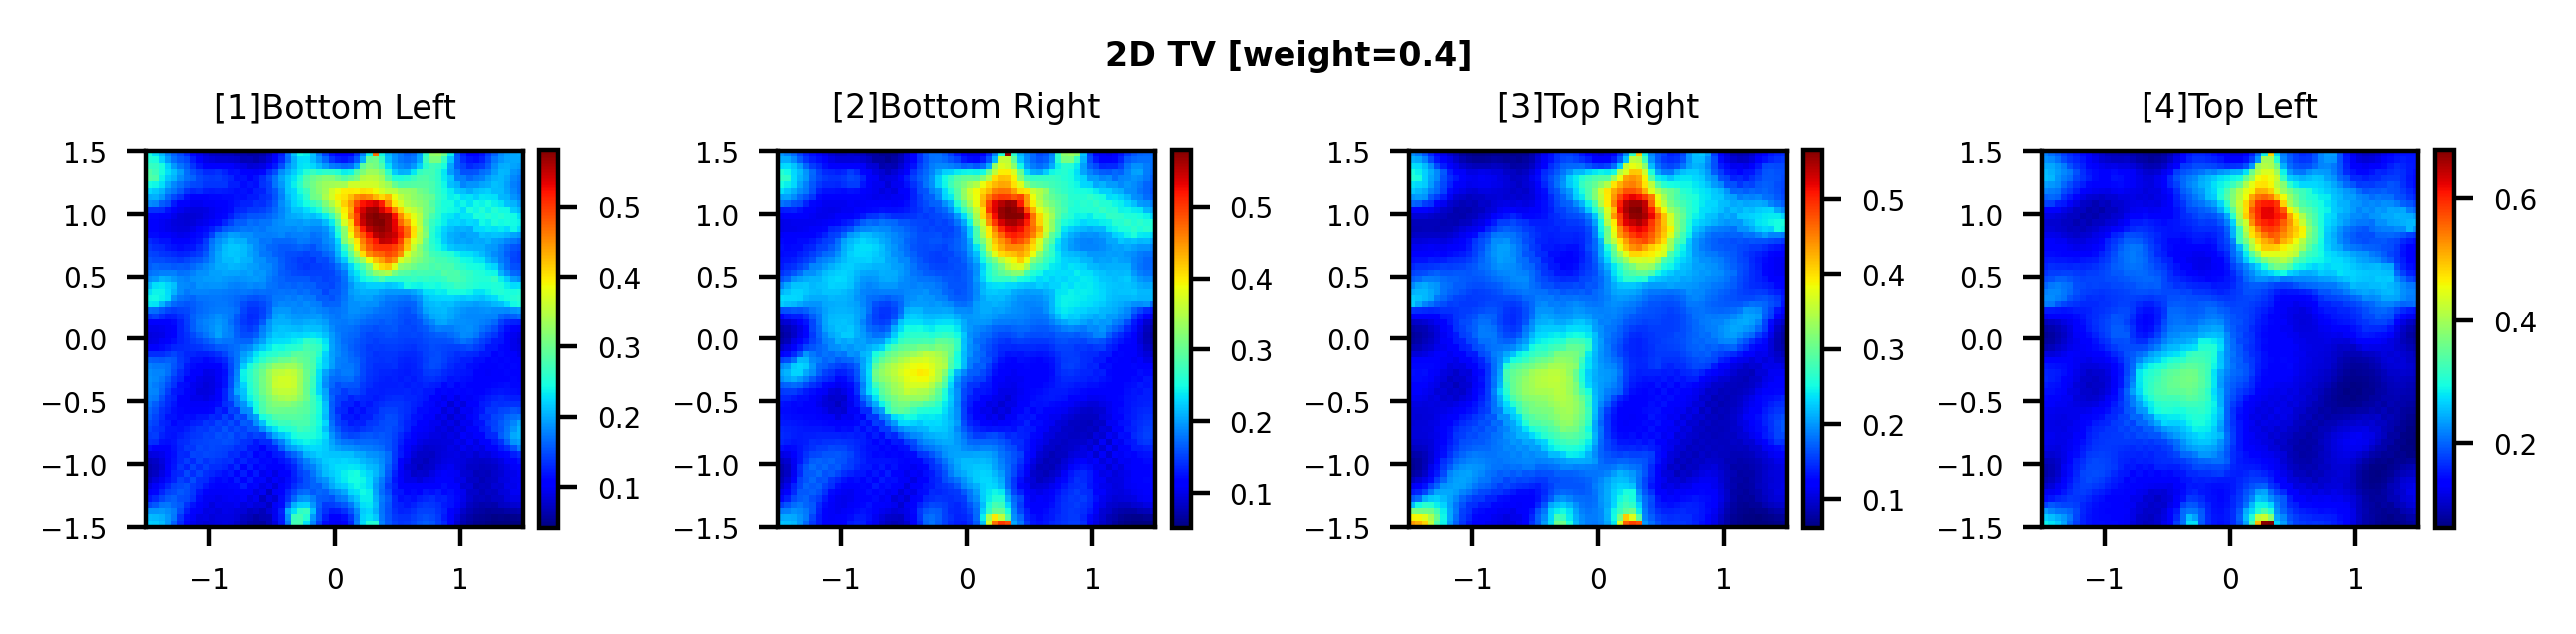

In [32]:
weight = 0.4

plot_test_ptot([denoise_tv_chambolle(x, weight=weight) for x in result], f'2D TV [{weight=}]')


In [33]:
result[0]

array([[0.38448983, 0.        , 0.14731042, ..., 0.14774565, 0.        ,
        0.24610294],
       [0.16117266, 0.52920241, 0.18891238, ..., 0.20122019, 0.21230469,
        0.39107168],
       [0.        , 0.58115467, 0.47531749, ..., 0.3102234 , 0.30883175,
        0.18554907],
       ...,
       [0.31961551, 0.15551755, 0.24273555, ..., 0.        , 0.0907558 ,
        0.09665527],
       [0.17076575, 0.3173788 , 0.22625695, ..., 0.        , 0.        ,
        0.        ],
       [0.29214095, 0.28819439, 0.36544435, ..., 0.        , 0.        ,
        0.        ]])

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

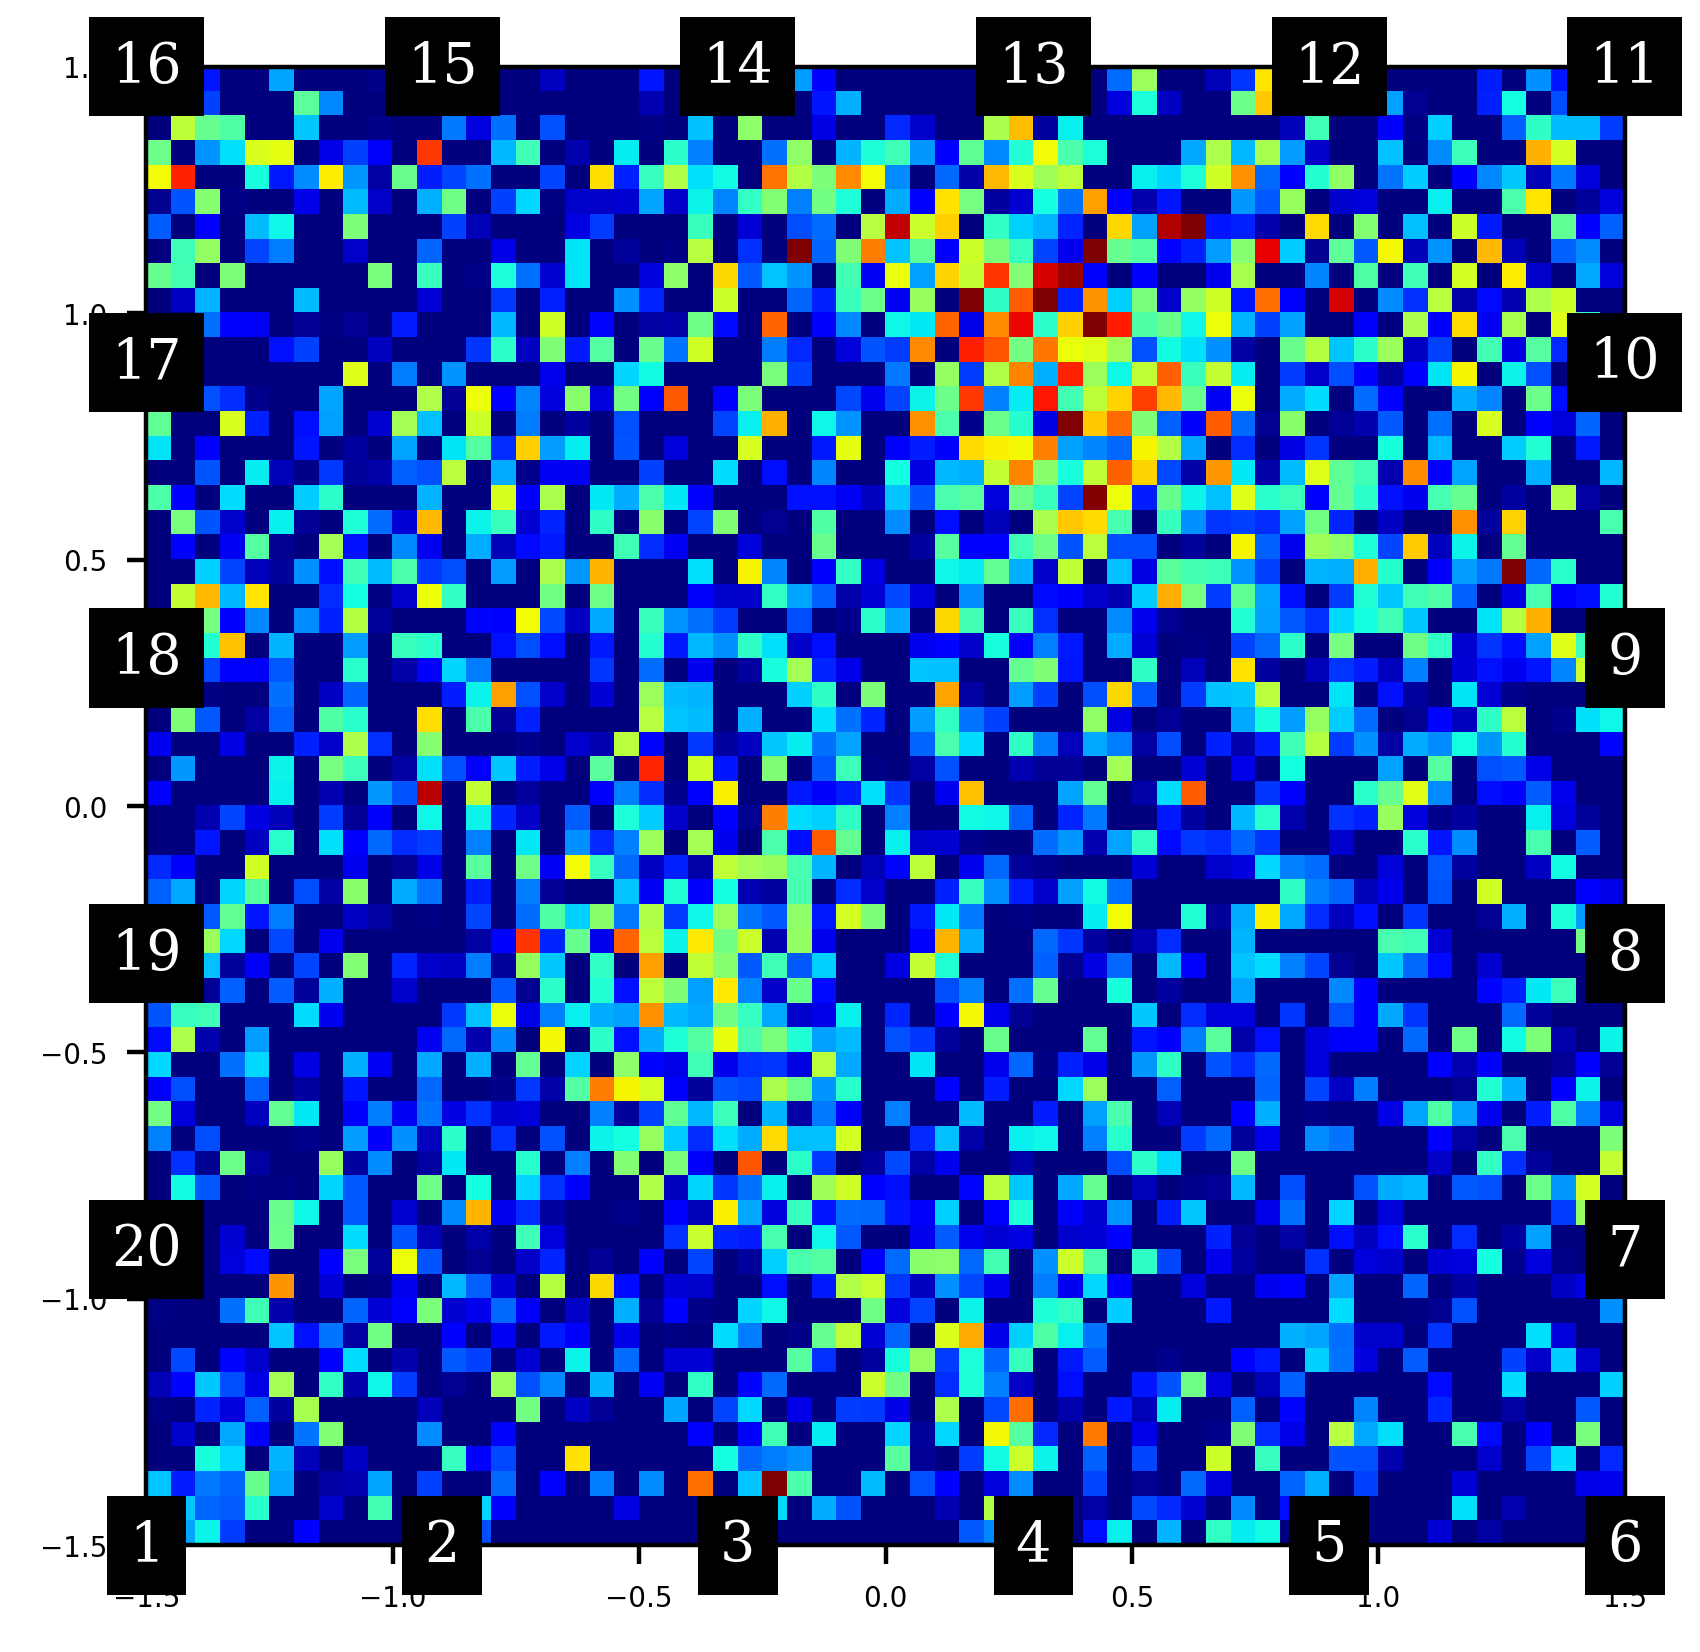

In [34]:
plt.imshow(result[0], vmin=0, vmax=1, cmap='jet',
                        extent=[-parameters['doi_size']/2, parameters['doi_size']/2, -parameters['doi_size']/2, parameters['doi_size']/2]
                        )
for i in range(parameters['num_devices']):
    plt.text(*parameters['device_coordinates'][i], s=i+1, va='center', ha='center',
                fontdict={'family': 'serif', 'color':  'white', 'weight': 'normal', 'size': 10},
                bbox=dict(facecolor='black', edgecolor='none'))
plt.imshow

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

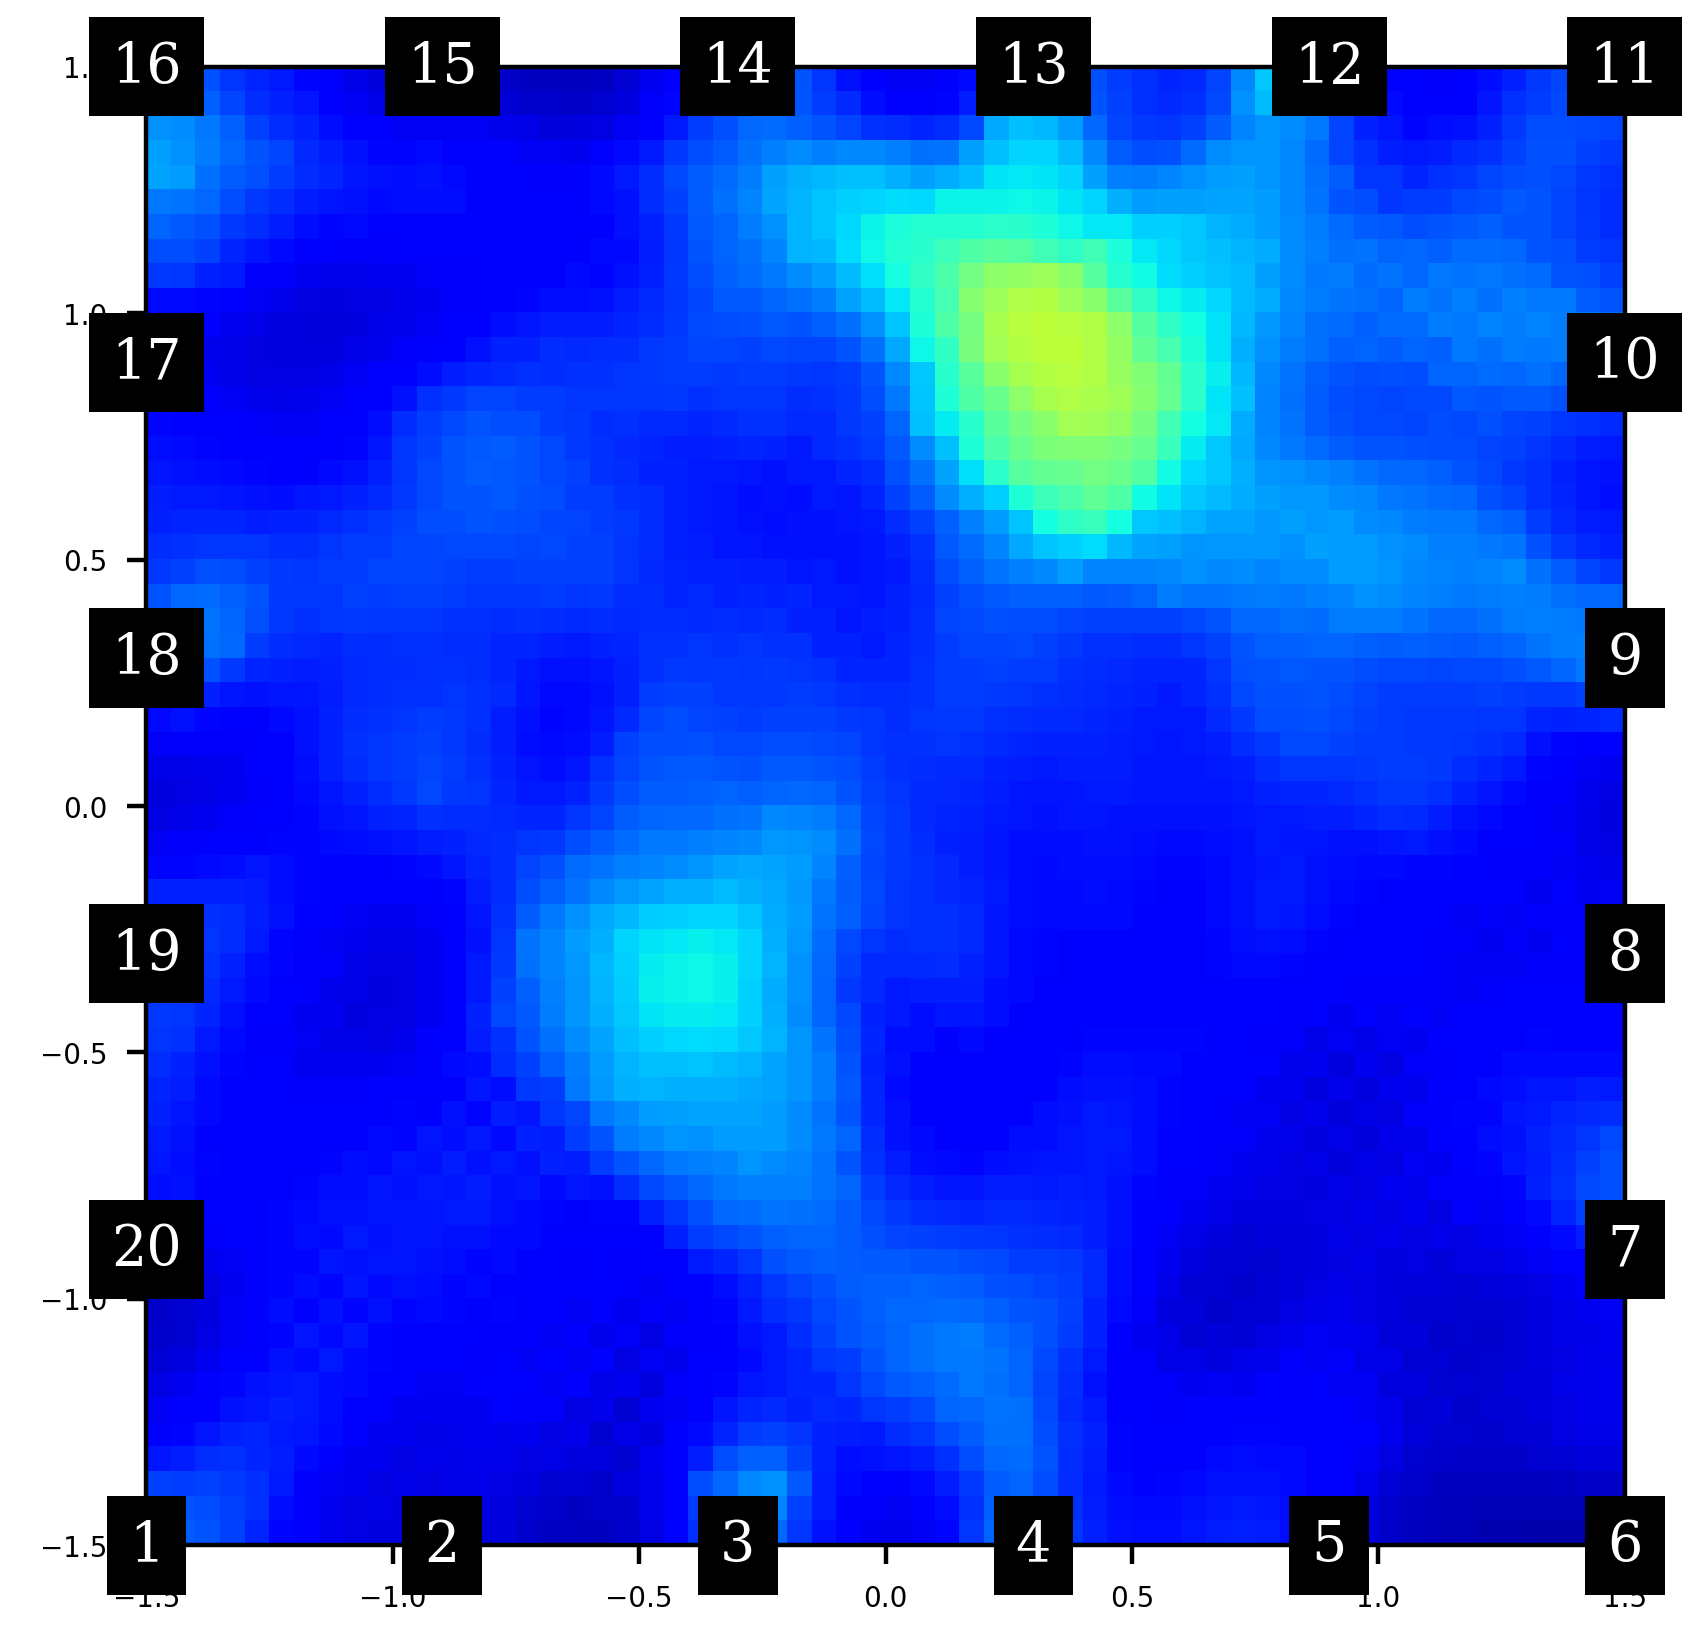

In [35]:
plt.imshow(denoise_tv_chambolle(result[0], 0.4), vmin=0, vmax=1, cmap='jet',
                        extent=[-parameters['doi_size']/2, parameters['doi_size']/2, -parameters['doi_size']/2, parameters['doi_size']/2]
                        )
for i in range(parameters['num_devices']):
    plt.text(*parameters['device_coordinates'][i], s=i+1, va='center', ha='center',
                fontdict={'family': 'serif', 'color':  'white', 'weight': 'normal', 'size': 10},
                bbox=dict(facecolor='black', edgecolor='none'))
plt.imshow

In [37]:
A = np.random.rand(20, 20)
B = np.random.rand(20, 20)



In [41]:
np.linalg.inv((A.T @ A) + 1 * np.eye(*A.shape)) @ A.T @ B

array([[ 3.47966867e-01,  1.01771635e-01, -1.05367584e-02,
         1.63256450e-01,  5.51794573e-02,  2.22956278e-01,
         1.51516316e-01,  1.11964284e-01,  1.08748868e-01,
         5.89817026e-02,  1.64429988e-01,  2.07542051e-01,
        -1.67539715e-02,  9.40535807e-02,  1.74063631e-01,
         1.00842789e-01,  1.18006495e-01,  6.73245089e-02,
         1.00045670e-01,  2.49126727e-01],
       [ 4.81041512e-02, -1.03177579e-01,  1.23690194e-01,
         1.03035618e-01, -1.63907145e-01,  1.10206170e-01,
         1.29797720e-01,  7.95513091e-02,  1.74574462e-01,
        -2.56835330e-01,  1.77270694e-01,  1.98586238e-01,
         7.25625231e-02,  6.67489353e-02, -1.14651411e-01,
         1.40093222e-01, -2.10009286e-01,  1.74258622e-01,
        -3.64681775e-02, -9.24335950e-02],
       [ 3.71879645e-02,  1.23066407e-01,  1.00164048e-01,
         3.67120318e-02, -2.97147573e-02,  1.64796014e-02,
        -2.14752654e-02,  7.51235362e-03, -1.88292892e-02,
         4.70036747e-03,  1.6

In [42]:
Dx = np.load('Dx.npy')
Dy = np.load('Dy.npy')

In [44]:
C = np.array([1, 2, 3])
C

array([1, 2, 3])

In [49]:
C[-1::-1]

array([3, 2, 1])

In [53]:
len([
            -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5,
            -1.2, -0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.9, 1.2, 1.5, 1.5, 1.5, 1.5,
            1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.2, 0.9, 0.6, 0.3, 0, -0.3,
            -0.6, -0.9, -1.2
        ])

40

In [54]:
sensor_x = [
            -1.5,
            -0.9,
            -0.3,
            0.3,
            0.9,
            1.5,
            1.5,
            1.5,
            1.5,
            1.5,
            1.5,
            0.9,
            0.3,
            -0.3,
            -0.9,
            -1.5,
            -1.5,
            -1.5,
            -1.5,
            -1.5,
        ]

In [56]:
len(sensor_x)

20

In [10]:
import numpy as np
Dx = np.load('Dx.npy')
Dy = np.load('Dy.npy')

In [11]:
Dx.shape

(3600, 3600)

In [12]:
def difference_operator(m, num_grids, direction):
    d_row = np.zeros((1, num_grids))
    d_row[0, 0] = 1

    if direction == "horizontal":
        d_row[0, 1] = -2
        d_row[0, 2] = 1

    elif direction == "vertical":
        d_row[0, m] = -2
        d_row[0, 2 * m] = 1

    else:
        raise ValueError("Invalid direction value for difference operator")

    rows = list()
    rows.append(d_row)
    for i in range(0, num_grids - 1):
        shifted_row = np.roll(d_row, 1)
        shifted_row[0, 0] = 0
        rows.append(shifted_row)
        d_row = shifted_row

    d = np.vstack([row for row in rows])
    return d


parameters = {}
parameters['pixel_size'] = (60, ) * 2
m = parameters['pixel_size'][0]
dim = m**2

Dx1 = difference_operator(m, dim, 'horizontal')
Dy2 = difference_operator(m, dim, 'vertical')

In [18]:
np.allclose(Dy, Dy2)

True

In [ ]:
def xPRA_test(parameters, FrytB, FrytBat, Pinc, Ptot):
    def quadratic_smoothing(parameters, Pryt, FrytB):
        def difference_operator(m, num_grids, direction):
            d_row = np.zeros((1, num_grids))
            d_row[0, 0] = 1

            if direction == "horizontal":
                d_row[0, 1] = -2
                d_row[0, 2] = 1

            elif direction == "vertical":
                d_row[0, m] = -2
                d_row[0, 2 * m] = 1

            else:
                raise ValueError("Invalid direction value for difference operator")

            rows = list()
            rows.append(d_row)
            for i in range(0, num_grids - 1):
                shifted_row = np.roll(d_row, 1)
                shifted_row[0, 0] = 0
                rows.append(shifted_row)
                d_row = shifted_row

            d = np.vstack([row for row in rows])
            return d

        m = parameters['pixel_size'][0]
        dim = m**2

        Dx = difference_operator(m, dim, 'horizontal')
        Dy = difference_operator(m, dim, 'vertical')

        return np.linalg.inv((FrytB.T @ FrytB) + parameters['alpha'] * (Dx.T @ Dx + Dy.T @ Dy)) @ FrytB.T

    Pryt = (Ptot-Pinc)/(20*np.log10(np.exp(1)))

    if not parameters['flag']:
        parameters['G'] = quadratic_smoothing(parameters, Pryt, FrytB)
        parameters['flag'] = True

    chi = (parameters['G'] @ Pryt).imag

    return chi.reshape(parameters['pixel_size'], order='F')
